# IBM Data Science Professional Certificate
## Applied Data Science Capstone - The Battle of Neighborhoods - Week 4 Part 1

#### Import the libraries and install Folium.

In [6]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

import matplotlib.pyplot as plt # plotting library
import matplotlib.cm as cm
import matplotlib.colors as colors
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed.')
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Sol

In [34]:
from IPython.display import Image
from IPython.core.display import HTML 

#### My Foursquare developer credentials to variables to use in URL later.

In [20]:
CLIENT_ID = 'RRASUCLEYDRO4ZOCHZJXWEJQE0CIOGPQOIGR2IYSQCKDVIY2' # your Foursquare ID
CLIENT_SECRET = 'VSTG5FLZDLF532ULJV0F5Z45BYQD3A1Q2XKXHZ4AN4SWLYLR' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 200
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RRASUCLEYDRO4ZOCHZJXWEJQE0CIOGPQOIGR2IYSQCKDVIY2
CLIENT_SECRET:VSTG5FLZDLF532ULJV0F5Z45BYQD3A1Q2XKXHZ4AN4SWLYLR


#### Assign other variables to be used in URL generation.

In [21]:
RADIUS = 500 # set the radius of the search (in meters). If radius is not specified, a suggested radius will be used based on the density of venues in the area.
category_food = '4d4b7105d754a06374d81259' # the top-level ID for Food based on https://developer.foursquare.com/docs/resources/categories

#### Get the latitude and longitude of Whitefield, Bengaluru, India to be used as our starting point.

In [22]:
address = 'Whitefield, Bengaluru, Karnataka'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("Whitefield is located at: ",latitude, longitude)

Whitefield is located at:  12.9963995 77.7614229


#### Create a URL dynamically to make API calls to Foursquare.

In [23]:
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, category_food, LIMIT)

#### Make the actual request to Foursquare and get the JSON results, assigning them to 'results' variable.

In [24]:
results = requests.get(url).json()
'There are {} food places around Whitefield.'.format(len(results['response']['groups'][0]['items']))

'There are 95 food places around Whitefield.'

#### Filter unwanted details & Assign the relevant parts of JSON to 'venues'.

In [25]:
venues = results['response']['groups'][0]['items']
#venues

#### Flatten the JSON data into a dataframe.

In [26]:
nearby_venues = json_normalize(venues)
#nearby_venues

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


#### Assign 'filtered_columns' with the column names we want to keep (Name, Categories, Lat, Lng).

In [27]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

#### Re-assign 'nearby_venues' dataframe to a dataframe containing only our 'filtered_columns'.
So far, the name, lat and lng are in a good place. Still need to clean up how categories are coming in.

In [28]:
nearby_venues = nearby_venues.loc[:, filtered_columns]
#nearby_venues

#### Define a function 'get_category_type' that we will use to clean up the categories in our dataframe.
This function goes row by row in the dataframe and looks for venue.categories or categories and if it finds them, it returns the 'name' of the category. Otherwise it returns 0.

In [29]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Run the 'get_category_type' function we created on the 'venue.categories' column and then clean the columns.

In [30]:
# run the function on venue.categories
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

#### Check the head rows to make sure all our steps produced the desired output.

In [31]:
nearby_venues.head()

name                   categories        lat        lng
0    Barbeque Nation                    BBQ Joint  12.987283  77.736093
1  M Cafe (Marriott)                   Restaurant  12.979192  77.728240
2           Latitude                   Restaurant  12.986769  77.737480
3          Pizza Hut                  Pizza Place  12.986671  77.736303
4   Herbs and Spices  Eastern European Restaurant  12.968145  77.750862

In [32]:
print('The area around Whitefield has {} types of food venues and {} individual venues.'.format(
        len(nearby_venues['categories'].unique()),
        nearby_venues.shape[0]
    )
)

The area around Whitefield has 32 types of food venues and 95 individual venues.


#### Check how this information looks visually using Folium.
Since we have a key location to start, let's mark it differently than all our venues.

In [35]:
# generate map centred around Whitefield
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) 

# add Whitefield as a red circle mark
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup='Whitefield',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)

# add popular spots to the map as blue circle markers
for lat, lng, label in zip(nearby_venues.lat, nearby_venues.lng, nearby_venues.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

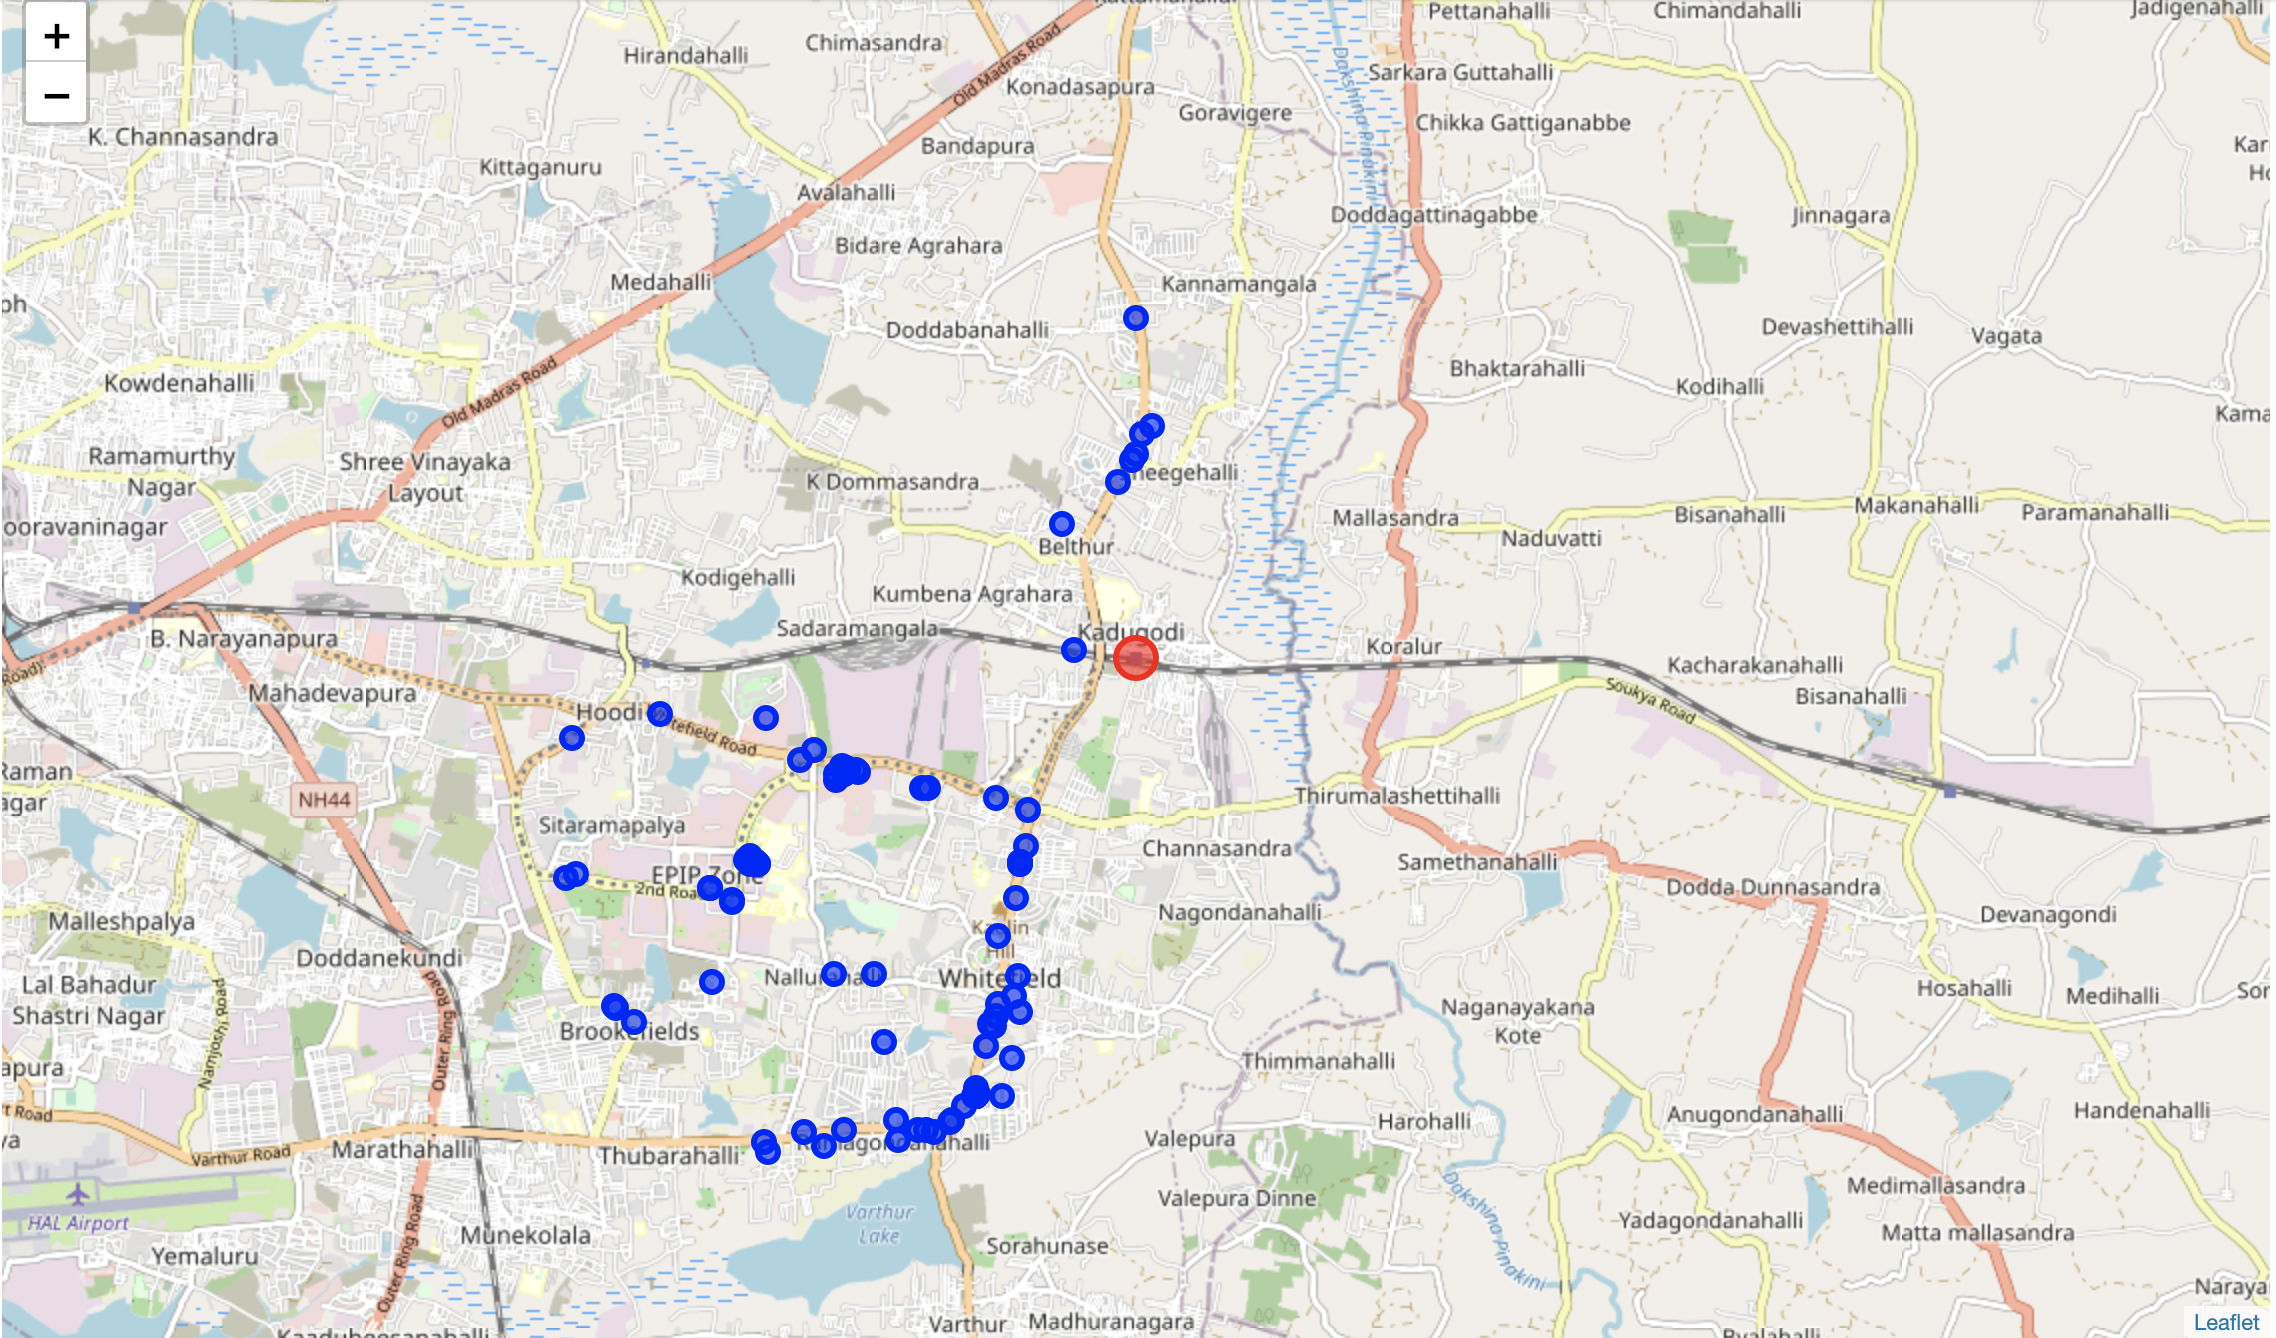

In [36]:
Image(filename = "week4-1.png")

### Seeking optimal *k*

In [37]:
# isolate just the lat lng columns as 'lat_lng'

cont_feat = ['lat', 'lng']
lat_lng = nearby_venues[cont_feat]
lat_lng.head()

lat        lng
0  12.987283  77.736093
1  12.979192  77.728240
2  12.986769  77.737480
3  12.986671  77.736303
4  12.968145  77.750862

In [38]:
# get a description of the lat / lon data.

nearby_venues[cont_feat].describe()

lat        lng
count  95.000000  95.000000
mean   12.976210  77.740166
std     0.015807   0.011862
min    12.955058  77.712532
25%    12.960122  77.731214
50%    12.978045  77.740873
75%    12.986721  77.749279
max    13.024762  77.762780

In [39]:
Ssd = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(nearby_venues[cont_feat])
    Ssd.append(km.inertia_)

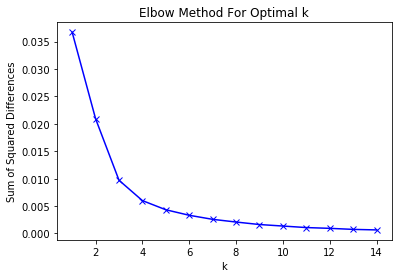

In [40]:
plt.plot(K, Ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Differences')
plt.title('Elbow Method For Optimal k')
plt.show()

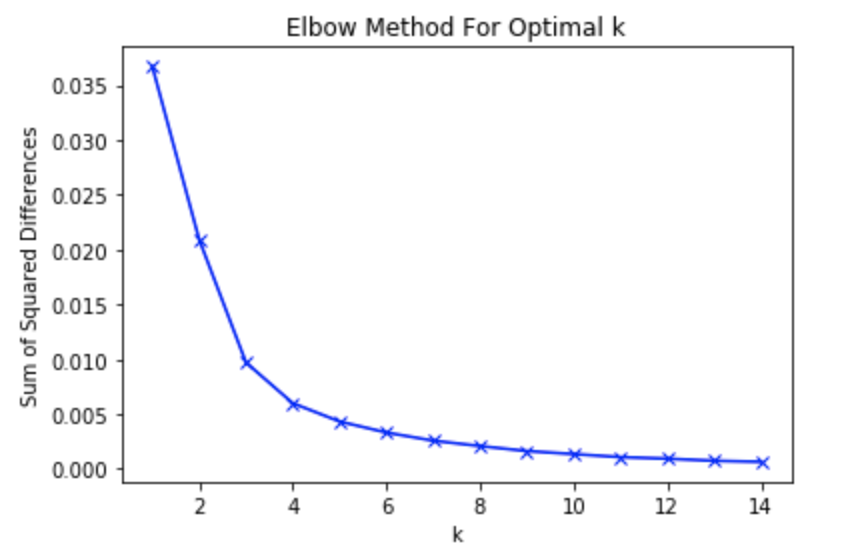

In [41]:
Image(filename = "week4-2.png")

This elbow method above doesn't have as distinct of an elbow as I would like.

To me, it seems like a good choice for k would be 2, 3 or 4. Rather than just pick a number, I want to look a bit closer at the rate of change between the points.

To do this, I'll cycle through the list of Ssd and calculate the difference between a list element and the previous list element. The returned list will be the rate of change starting with the 2nd point.

In [45]:
#show the values in the chart above, for easier understanding of the math.

Ssd

[0.03671324096623032,
 0.020934860355483097,
 0.009708472459009219,
 0.005996176005480657,
 0.00432662320414353,
 0.003318800430024538,
 0.002578204525023549,
 0.0020874345360951145,
 0.001631411415906872,
 0.0013559306640447836,
 0.0010775591294570068,
 0.0009362674494667766,
 0.0007451885477507126,
 0.0006487993946220898]

In [46]:
# take a given list element (starting with the 2nd one) and subtract the previous list element from it.
# For example, 0.0294 - 0.0855 for the first entry returns -0.056
# Repeat for the entire list.

[j-i for i, j in zip(Ssd[:-1], Ssd[1:])]

[-0.01577838061074722,
 -0.011226387896473879,
 -0.0037122964535285614,
 -0.0016695528013371272,
 -0.0010078227741189922,
 -0.0007405959050009888,
 -0.0004907699889284346,
 -0.00045602312018824245,
 -0.00027548075186208847,
 -0.00027837153458777674,
 -0.00014129167999023023,
 -0.00019107890171606403,
 -9.638915312862274e-05]

As I review this rate of change in the chart, I really start to see the sum of squares taper off after the 4th <i>k</i>.

For the remainder of this exercise, I'm going to use <b><i>k</i> = 4</b> for my clusters.

This covers everything I set out to do in "Step 2" of my Data section above.

### Setting up *k*-means

The KMeans class has many parameters that can be used, but we will use these three:
<ul>
    <li> <b>init</b>: Initialization method of the centroids. </li>
    <ul>
        <li> Value will be: "k-means++". k-means++ selects initial cluster centers for <i>k</i>-means clustering in a smart way to speed up convergence.</li>
    </ul>
    <li> <b>n_clusters</b>: The number of clusters to form as well as the number of centroids to generate. </li>
    <ul> <li> Value will be: 4 (the number we determined in our previous step)</li> </ul>
    <li> <b>n_init</b>: Number of times the <i>k</i>-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia. </li>
    <ul> <li> Value will be: 15 </li> </ul>
</ul>

Initialize KMeans with these parameters, where the output parameter is called **k_means**.

In [69]:
k_val = 4

In [70]:
k_means = KMeans(init="k-means++", n_clusters= k_val, n_init=15)

In [71]:
# let's fit our latitudes and longitude data into clusters.

k_means.fit(lat_lng)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=15, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [72]:
# label each venue with a cluster

k_means_labels = k_means.labels_
k_means_labels

array([1, 3, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 1, 3, 1, 3, 2,
       0, 2, 3, 0, 3, 0, 3, 3, 1, 1, 3, 0, 0, 0, 0, 1, 1, 3, 1, 1, 3, 1,
       1, 1, 0, 1, 0, 3, 0, 1, 3, 0, 1, 0, 2, 3, 1, 1, 2, 1, 1, 3, 2, 1,
       2, 1, 1, 1, 3, 0, 3, 0, 1, 3, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0], dtype=int32)

In [73]:
# add the cluster label to our 'nearby_venues' dataframe for a complete view

nearby_venues["Cluster"] = k_means_labels
nearby_venues.head(10)

name                     categories        lat        lng  \
0      Barbeque Nation                      BBQ Joint  12.987283  77.736093   
1    M Cafe (Marriott)                     Restaurant  12.979192  77.728240   
2             Latitude                     Restaurant  12.986769  77.737480   
3            Pizza Hut                    Pizza Place  12.986671  77.736303   
4     Herbs and Spices    Eastern European Restaurant  12.968145  77.750862   
5  Adyar Ananda Bhavan  Vegetarian / Vegan Restaurant  12.983675  77.752145   
6      Salt Mango Tree                     Restaurant  12.959806  77.749909   
7         Cafe Palmyra                     Restaurant  12.964198  77.739712   
8              Toscano             Italian Restaurant  12.959788  77.747603   
9         The Fat Chef              Indian Restaurant  12.957701  77.740873   

   Cluster  
0        1  
1        3  
2        1  
3        1  
4        0  
5        1  
6        0  
7        0  
8        0  
9        0

In [74]:
# Identify the centers (mean) of each cluster and assign to 'clus_center'

clus_center = nearby_venues.groupby('Cluster').mean().reset_index('Cluster')
clus_center

Cluster        lat        lng
0        0  12.961322  77.744758
1        1  12.985159  77.740693
2        2  13.012173  77.759911
3        3  12.977517  77.723631

In [85]:
# generate map centred around Whitefield including new clusters
c_venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) 

# set color scheme for clusters
x = np.arange(k_val)
ys = [i + x + (i*x)**2 for i in range(k_val)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

marker_colors = []

# add popular spots to the map as blue circle markers
for lat, lng, poi, cat,  cluster in zip(nearby_venues["lat"], nearby_venues["lng"], nearby_venues["name"], nearby_venues["categories"], nearby_venues["Cluster"]):
    venue_label = folium.Popup(str(poi) + ' (' + str(cat) + ') Cluster: '+ str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=venue_label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
        ).add_to(c_venues_map)

# add Whitefield as a pink circle mark with black fill
folium.features.CircleMarker(
    [latitude, longitude],
    radius=8,
    popup='Whitefield',
    fill=True,
    color='#fb14ff',
    fill_color='black',
    fill_opacity=0.9
    ).add_to(c_venues_map)

# add centers as a black circle with pink fill
for lat, lng, cluster in zip(clus_center["lat"], clus_center["lng"], clus_center["Cluster"]):
    ctr_label = folium.Popup('Center of Cluster: '+ str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=ctr_label,
        fill=True,
        color='black',
        fill_color='#fb14ff',
        fill_opacity=0.9
        ).add_to(c_venues_map)

# display map
c_venues_map

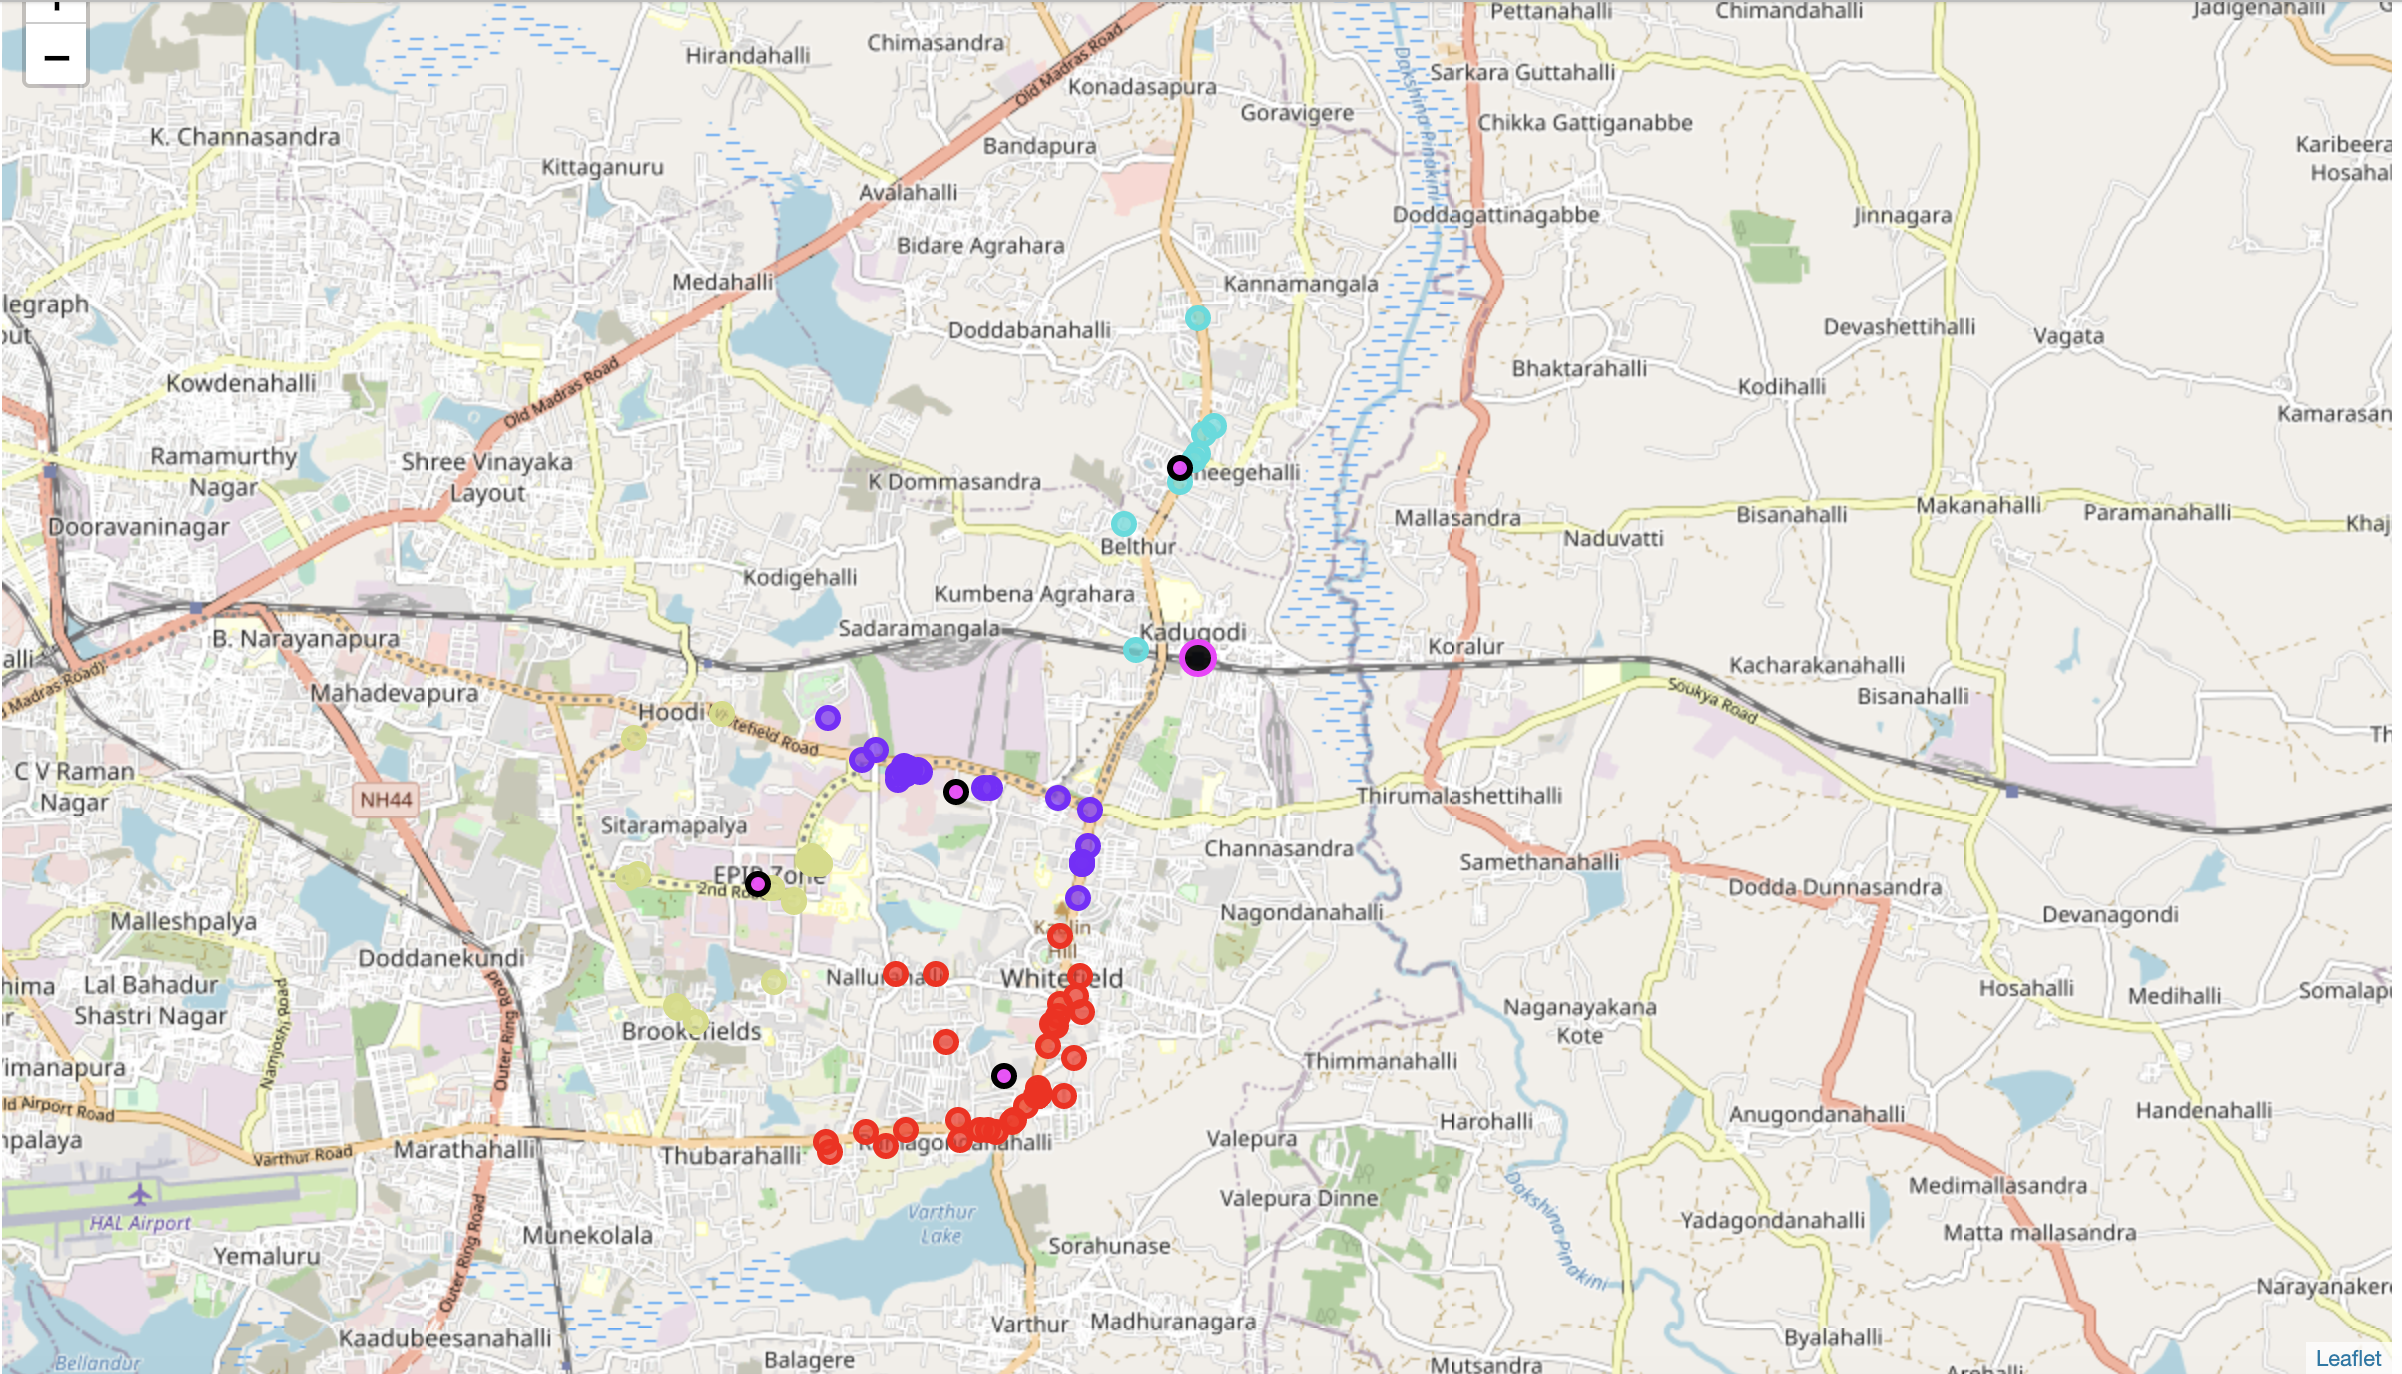

In [77]:
Image(filename = "week4-3.png")

This map displays each of the venues color coded by cluster. I've additionally added a mark for Whitefield (pink circle, black fill) and the centers for each cluster (black circle, pink fill).

This concludes what I intended to accomplish in "Step 3".

Now it is time to start comparing the clusters.

### Examine the Clusters

To start, let's look at the top types of venues in each cluster.

In [78]:
# reminder of what our current data table looks like

nearby_venues.head()

name                   categories        lat        lng  \
0    Barbeque Nation                    BBQ Joint  12.987283  77.736093   
1  M Cafe (Marriott)                   Restaurant  12.979192  77.728240   
2           Latitude                   Restaurant  12.986769  77.737480   
3          Pizza Hut                  Pizza Place  12.986671  77.736303   
4   Herbs and Spices  Eastern European Restaurant  12.968145  77.750862   

   Cluster  
0        1  
1        3  
2        1  
3        1  
4        0

In [79]:
# how many venues do we have in each cluster
nearby_venues.groupby("Cluster").count()

name  categories  lat  lng
Cluster                            
0          38          38   38   38
1          28          28   28   28
2           8           8    8    8
3          21          21   21   21

So it looks like we have 13 locations in Cluster 0, 53 locations in Cluster 1, 19 locations in Cluster 2, and 15 locations in Cluster 3.

In [80]:
print('Overall, there are {} uniques categories.'.format(len(nearby_venues["categories"].unique())))

Overall, there are 32 uniques categories.


Now we're going to one hot encode each of the categories so we can run analysis on each cluster.

In [81]:
# one hot encoding
nearby_onehot = pd.get_dummies(nearby_venues[["categories"]], prefix="", prefix_sep="")

# add cluster column back to dataframe
nearby_onehot["Cluster"] = nearby_venues["Cluster"] 

# move cluster column to the first column
fixed_columns = [nearby_onehot.columns[-1]] + list(nearby_onehot.columns[:-1])
nearby_onehot = nearby_onehot[fixed_columns]

nearby_onehot.head()

Cluster  American Restaurant  Asian Restaurant  Australian Restaurant  \
0        1                    0                 0                      0   
1        3                    0                 0                      0   
2        1                    0                 0                      0   
3        1                    0                 0                      0   
4        0                    0                 0                      0   

   BBQ Joint  Bakery  Breakfast Spot  Café  Chaat Place  Chinese Restaurant  \
0          1       0               0     0            0                   0   
1          0       0               0     0            0                   0   
2          0       0               0     0            0                   0   
3          0       0               0     0            0                   0   
4          0       0               0     0            0                   0   

   ...  Multicuisine Indian Restaurant  North Indian Restaurant  Pizza Place  \
0  ...                               0                        0            0   
1  ...                               0                        0            0   
2  ...                               0                        0            0   
3  ...                               0                        0            1   
4  ...                               0                        0            0   

   Rajasthani Restaurant  Restaurant  Sandwich Place  Snack Place  \
0                      0           0               0            0   
1                      0           1               0            0   
2                      0           1               0            0   
3                      0           0               0            0   
4                      0           0               0            0   

   Swiss Restaurant  Udupi Restaurant  Vegetarian / Vegan Restaurant  
0                 0                 0                              0  
1                 0                 0                              0  
2                 0                 0                              0  
3                 0                 0                              0  
4                 0                 0                              0  

[5 rows x 33 columns]

In [82]:
# examine the new dataframe

nearby_onehot.shape

(95, 33)

In [83]:
# group the rows by the cluster # by taking the mean of each frequency

nearby_grouped = nearby_onehot.groupby("Cluster").mean().reset_index()
nearby_grouped

Cluster  American Restaurant  Asian Restaurant  Australian Restaurant  \
0        0             0.026316          0.026316               0.000000   
1        1             0.035714          0.000000               0.035714   
2        2             0.000000          0.125000               0.000000   
3        3             0.000000          0.000000               0.000000   

   BBQ Joint    Bakery  Breakfast Spot      Café  Chaat Place  \
0   0.000000  0.078947        0.000000  0.131579     0.000000   
1   0.071429  0.000000        0.000000  0.142857     0.035714   
2   0.000000  0.000000        0.000000  0.000000     0.000000   
3   0.000000  0.047619        0.047619  0.095238     0.000000   

   Chinese Restaurant  ...  Multicuisine Indian Restaurant  \
0            0.026316  ...                        0.026316   
1            0.035714  ...                        0.000000   
2            0.000000  ...                        0.000000   
3            0.047619  ...                        0.000000   

   North Indian Restaurant  Pizza Place  Rajasthani Restaurant  Restaurant  \
0                    0.000     0.131579               0.026316    0.105263   
1                    0.000     0.035714               0.000000    0.035714   
2                    0.125     0.125000               0.000000    0.125000   
3                    0.000     0.047619               0.000000    0.095238   

   Sandwich Place  Snack Place  Swiss Restaurant  Udupi Restaurant  \
0        0.026316     0.000000          0.026316             0.000   
1        0.035714     0.035714          0.000000             0.000   
2        0.125000     0.000000          0.000000             0.125   
3        0.000000     0.047619          0.000000             0.000   

   Vegetarian / Vegan Restaurant  
0                       0.026316  
1                       0.035714  
2                       0.000000  
3                       0.000000  

[4 rows x 33 columns]

In [84]:
# Let's look at the 5 most common categories per cluster

num_top_venues = 5

for cluster in nearby_grouped["Cluster"]:
        print("----- Cluster: "+str(cluster)+" -----")
        temp = nearby_grouped[nearby_grouped["Cluster"] == cluster].T.reset_index()
        temp.columns = ["categories", "freq"]
        temp = temp.iloc[1:]
        temp["freq"] = temp["freq"].astype(float)
        temp = temp.round({"freq": 2})
        print(temp.sort_values("freq", ascending=False).reset_index(drop=True).head(num_top_venues))
        print("\n")

----- Cluster: 0 -----
          categories  freq
0               Café  0.13
1        Pizza Place  0.13
2  Indian Restaurant  0.13
3         Restaurant  0.11
4             Bakery  0.08


----- Cluster: 1 -----
                    categories  freq
0            Indian Restaurant  0.21
1                         Café  0.14
2         Fast Food Restaurant  0.11
3  Eastern European Restaurant  0.07
4                    BBQ Joint  0.07


----- Cluster: 2 -----
                categories  freq
0              Pizza Place  0.12
1               Restaurant  0.12
2     Fast Food Restaurant  0.12
3  North Indian Restaurant  0.12
4        Indian Restaurant  0.12


----- Cluster: 3 -----
             categories  freq
0     Indian Restaurant  0.19
1  Fast Food Restaurant  0.14
2            Restaurant  0.10
3                  Café  0.10
4            Donut Shop  0.05




This completes what I wanted to accomplish for "Step 4".

For "Step 5", we can use the lists above to quickly see that Indian Restaurants are the #1 most common venue in clusters 1 & 3 with high freq, but in clusters 0 & 2, Indian Restaurants are yet to show their prominence in their respective clusters.

At this point, I can recommend my friend to look into an Indian Restaurants within the area defined as Cluster 0 & 2.

This completes "Step 5" through "Step 7" just by reviewing this data. Since my clusters are not very large, I will not be re-doing the entire process to reach a more conclusive results by expanding the parameters.

#### Thank you for taking the time to review my project. Please leave some notes / critiques so that I can improve in the future.